In [79]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis import plot
from toy_cis.models import CisConfig, Cis
from toy_cis.util import threshold_matrix


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [3]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA GeForce RTX 3090'


## simple-relu

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h + b
$$

In [66]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x=(sparse feature vals on [-1, 1]) and y=abs(x)."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, F.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

### Polysemanticity of neurons with n_feat=100, n_neurons=40, S=0.99

In [67]:
"""Create model."""

layer_act_fns = [F.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=40,
    act_fn=layer_act_fns,
    b1=None,
    b2=0.0,
)

simple_relu_model = Cis(simple_relu_cfg, device=device).to(device)

In [71]:
"""Train model."""

batch_sz = 128
feat_sparsity = 0.99
feat_importance = 1
n_steps = 5000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(simple_relu_model.parameters())

train(
    simple_relu_model,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.0009796491358429193,
 0.0007538345525972545,
 0.0009530963725410402,
 0.0009651510044932365,
 0.000897529476787895,
 0.0008995852549560368,
 0.0011620353907346725,
 0.0009843296138569713,
 0.0010654930956661701,
 0.0010461732745170593,
 0.001276524504646659]

l1_weights.shape=(40, 100)


Text(0.5, 1.0, 'Feature weights per neuron')

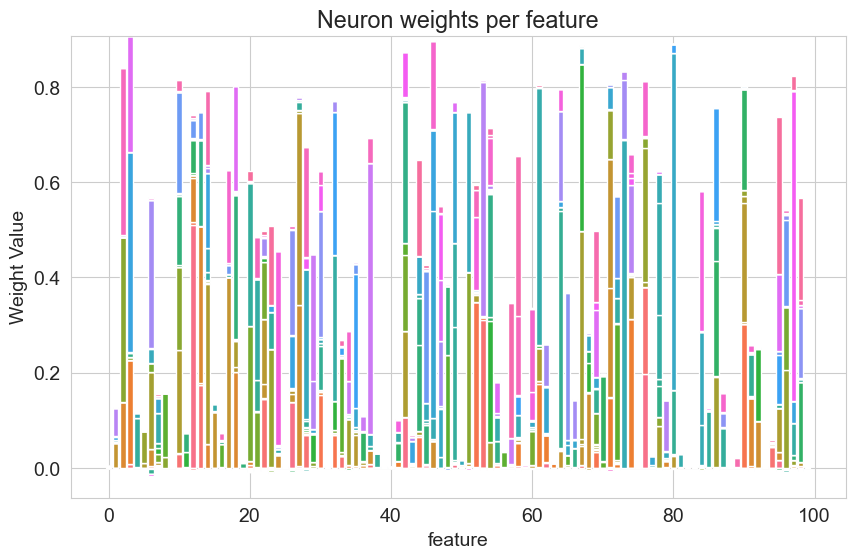

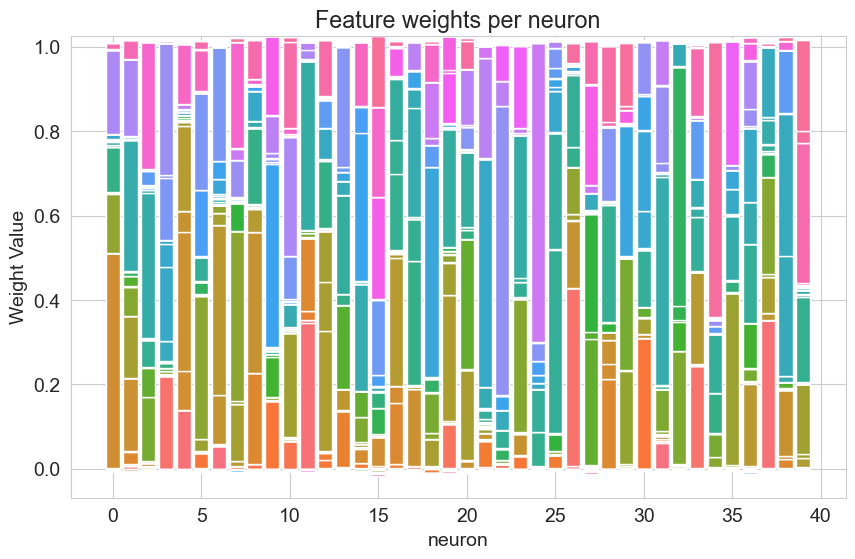

In [ ]:
"""Plot weights for neurons per feature, and for features per neuron."""

l1_weights = threshold_matrix(asnumpy(simple_relu_model.W1).squeeze(), threshold=0.01)
l2_weights = threshold_matrix(asnumpy(simple_relu_model.W2).squeeze(), threshold=0.01)
l1_weights = einsum(l1_weights, l2_weights, "neuron feature, feature neuron-> neuron feature")

print(f"{l1_weights.shape=}")

plt.rcParams.update({"font.size": 14})

fig = plot.plot_weight_bars(l1_weights, xax="feature")
fig.get_axes()[0].set_title("Neuron weights per feature")

fig = plot.plot_weight_bars(l1_weights.T, xax="neuron")
fig.get_axes()[0].set_title("Feature weights per neuron")

In [297]:
frac_nonzero

array([0.5  , 0.45 , 0.475, 0.475, 0.375, 0.3  , 0.325, 0.2  , 0.375,
       0.375, 0.45 , 0.525, 0.375, 0.5  , 0.425, 0.35 , 0.725, 0.225,
       0.475, 0.35 , 0.425, 0.575, 0.475, 0.475, 0.425, 0.4  , 0.45 ,
       0.525, 0.325, 0.45 , 0.525, 0.5  , 0.45 , 0.5  , 0.475, 0.4  ,
       0.175, 0.5  , 0.45 , 0.45 , 0.425, 0.475, 0.3  , 0.45 , 0.325,
       0.475, 0.425, 0.475, 0.425, 0.425, 0.375, 0.325, 0.475, 0.575,
       0.275, 0.3  , 0.525, 0.625, 0.575, 0.4  , 0.45 , 0.525, 0.35 ,
       0.475, 0.375, 0.375, 0.6  , 0.425, 0.35 , 0.6  , 0.5  , 0.425,
       0.35 , 0.3  , 0.475, 0.55 , 0.45 , 0.55 , 0.425, 0.5  , 0.225,
       0.45 , 0.325, 0.4  , 0.525, 0.2  , 0.475, 0.475, 0.4  , 0.425,
       0.35 , 0.5  , 0.525, 0.275, 0.375, 0.5  , 0.475, 0.3  , 0.525,
       0.45 ])

Text(0.5, 1.0, 'Distribution of nonzero neuron weights per feature')

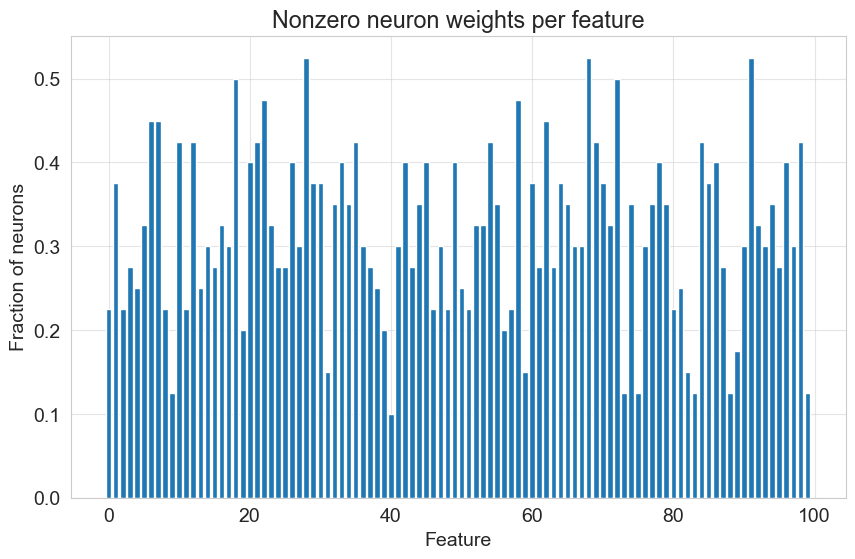

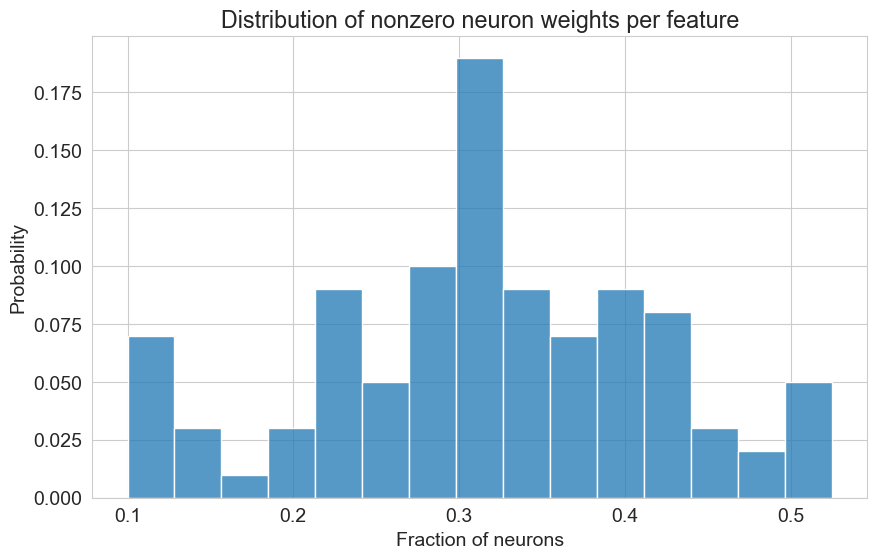

In [162]:
"""Plot nonzero neuron weights per feature."""

nonzero_counts = np.count_nonzero(l1_weights, axis=0)  # nonzero neuron weights per feature
frac_nonzero = nonzero_counts / simple_relu_model.cfg.n_hidden

# Plot nonzero_counts per feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(nonzero_counts)), frac_nonzero)
ax.set_xlabel("Feature")
ax.set_ylabel("Fraction of neurons")
ax.set_title("Nonzero neuron weights per feature")
ax.grid(True, alpha=0.5)

# Plot distribution of nonzero_counts
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(frac_nonzero, bins=15, stat="probability", ax=ax)
ax.set_xlabel("Fraction of neurons")
ax.set_title("Distribution of nonzero neuron weights per feature")
# ax.set_xticks(range(8, 27, 2))

### How many features are learned? or What is loss per feature?

Text(0.5, 1.0, 'Loss per feature, for 1000 examples per feature')

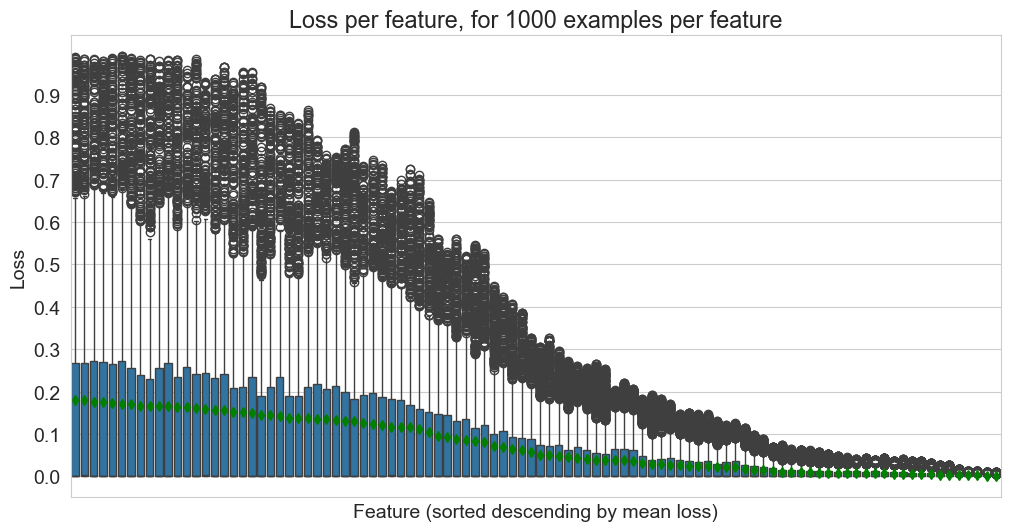

In [131]:
"""Box of loss per feature, ranked from highest mean loss to lowest."""

n_examples = 1000
losses = t.zeros((n_examples, simple_relu_model.cfg.n_feat), device=device)

# Activate only one feature at a time and calculate loss for that feature; loop for all features
for feat in range(simple_relu_model.cfg.n_feat):
    x = t.zeros(
        n_examples, simple_relu_model.cfg.n_instances, simple_relu_model.cfg.n_feat, device=device
    )
    # make only feat-th feature active
    x[:, :, feat] = rearrange((t.rand(n_examples) * 2 - 1), "n -> n 1")
    y_true = F.relu(x)
    y = simple_relu_model.forward(x)
    losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()

sorted_idxs = t.argsort(reduce(losses, "example feat -> feat", "mean"), descending=True)
losses = losses[:, sorted_idxs]
sorted_idxs = asnumpy(sorted_idxs)
df = pd.DataFrame(asnumpy(losses))
df_melted = df.melt(var_name="Feature", value_name="Loss")

fig, ax = plt.subplots(figsize=(12, 6))
meanprops = dict(marker="d", markerfacecolor="green", markeredgecolor="green", markersize=5)
sns.boxplot(data=df_melted, x="Feature", y="Loss", ax=ax, showmeans=True, meanprops=meanprops)

ax.set_xticks([], [])  # Hide x-axis labels if too many
ax.set_xlabel("Feature (sorted descending by mean loss)")
ax.set_ylabel("Loss")
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_title(f"Loss per feature, for {n_examples} examples per feature")

Text(0.5, 1.0, 'Distribution of mean loss per feature')

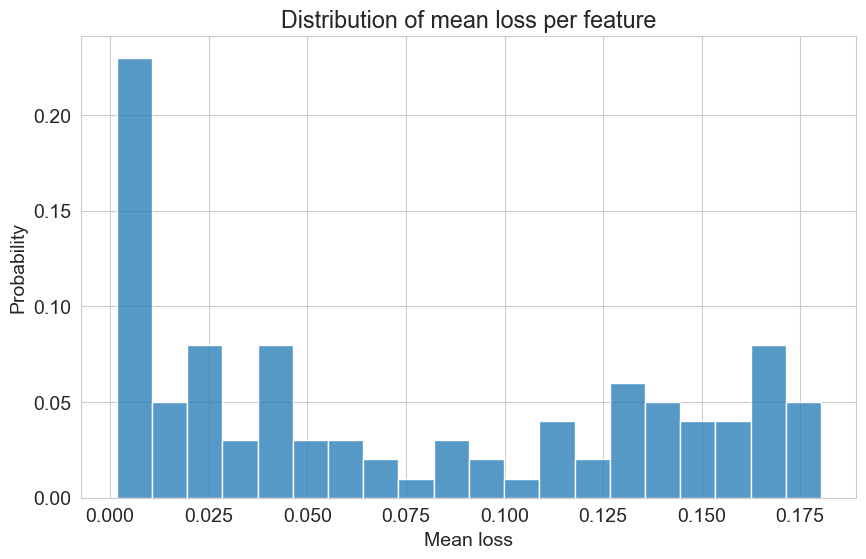

In [136]:
"""Distribution of mean loss per feature."""

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    asnumpy(reduce(losses, "example feat -> feat", "mean")), bins=20, stat="probability", ax=ax
)
ax.set_xlabel("Mean loss")
ax.set_title("Distribution of mean loss per feature")

### Loss and polysemanticity as a function of sparsity

- Per sparsity level (e.g. [0.05 : 0.95 : 0.05]) plot, as ridge plots (1 plot/row per sparsity level)
  
  1. polysemanticity (distribution of nonzero weights per feature)
  
  2. distribution of loss per feature (with final loss at end of training in figure title)


In [ ]:
"""Get polysemanticity and loss for set of sparsities."""

plt.rcParams.update({"font.size": 12})
sparsities = np.round(np.linspace(0.01, 0.99, 20), 2)
batch_sz = 128
feat_importance = 1
n_steps = 5000
logging_freq = n_steps // 10

poly_data = []  # will become a df with cols ["sparsity", "fraction_nonzero"]
loss_data = []  # will become a df with cols ["sparsity", "mean_loss"]

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model.
    simple_relu_model = Cis(simple_relu_cfg, device=device).to(device)
    optimizer = t.optim.Adam(simple_relu_model.parameters())
    losses = train(
        simple_relu_model,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity of neurons (frac of nonzero neuron weights per feature).
    l1_weights = threshold_matrix(asnumpy(simple_relu_model.W1).squeeze(), threshold=0.01)
    l2_weights = threshold_matrix(asnumpy(simple_relu_model.W2).squeeze(), threshold=0.01)
    l1_weights = einsum(l1_weights, l2_weights, "neuron feature, feature neuron-> neuron feature")
    nonzero_counts = np.count_nonzero(l1_weights, axis=0)  # nonzero neuron weights per feature
    frac_nonzero = nonzero_counts / simple_relu_model.cfg.n_hidden
    for val in frac_nonzero:
        poly_data.append({"sparsity": s, "frac_nonzero": val})

    # Get mean loss per feature.
    n_examples = 1000
    losses = t.zeros((n_examples, simple_relu_model.cfg.n_feat), device=device)
    # Activate only one feature at a time and calculate loss for that feature; loop for all features
    with t.no_grad():
        for feat in range(simple_relu_model.cfg.n_feat):
            x = t.zeros(
                n_examples, simple_relu_model.cfg.n_instances, simple_relu_model.cfg.n_feat, device=device
            )
            # make only feat-th feature active
            x[:, :, feat] = rearrange((t.rand(n_examples) * 2 - 1), "n -> n 1")
            y_true = F.relu(x)
            y = simple_relu_model.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for val in mean_losses:
        loss_data.append({"sparsity": s, "mean_loss": val})


Training over sparsities:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

C:\Users\jai\AppData\Local\Temp\ipykernel_23236\426888666.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_poly.set_yticklabels((ax_poly.get_yticks() * len(sparsities)).round(1).astype(str))


Text(0.5, 1.0, 'Distribution of mean loss per feature on n_examples=1000 (across sparsities)')

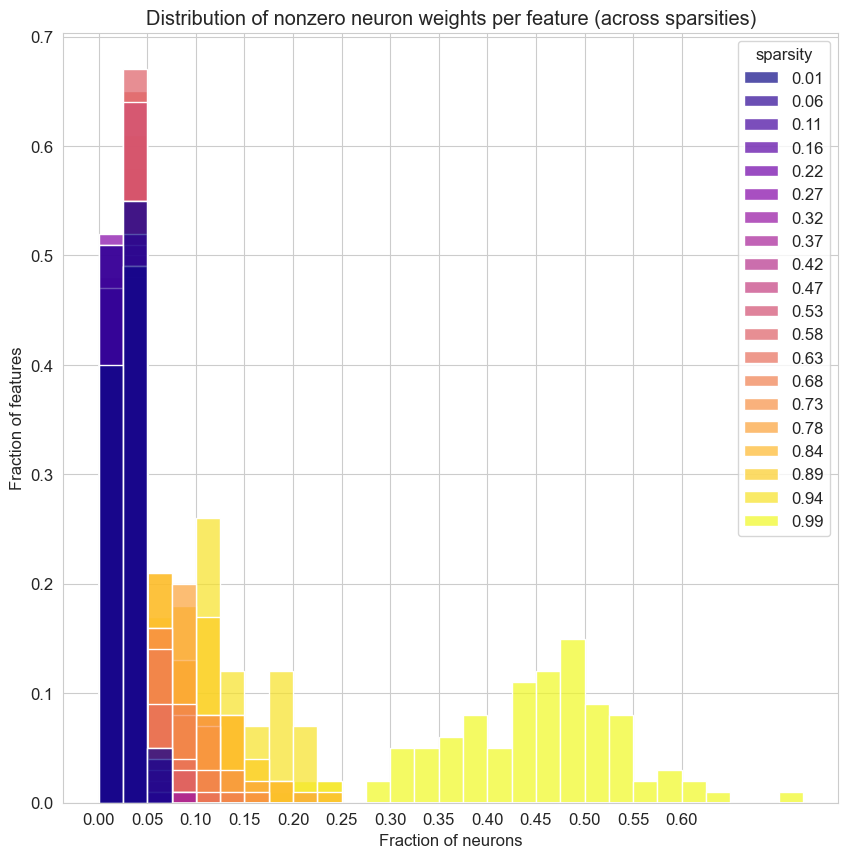

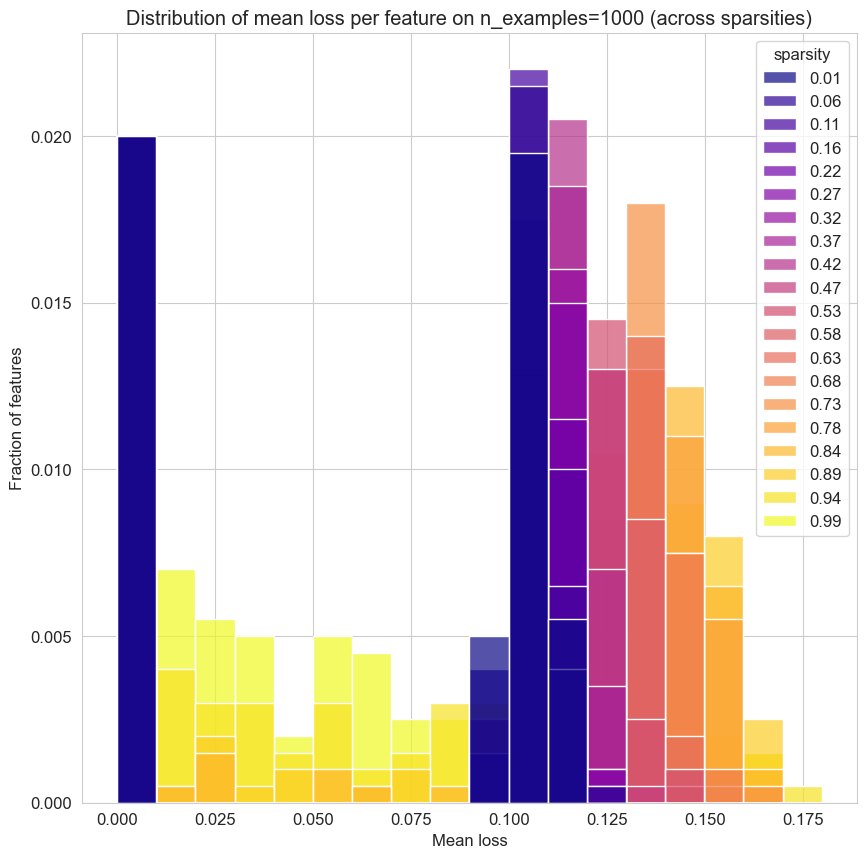

In [ ]:
"""Plot polysemanticity and loss for set of sparsities."""

fig_poly, ax_poly = plt.subplots(figsize=(10, 10))
fig_loss, ax_loss = plt.subplots(figsize=(10, 10))

df_poly = pd.DataFrame(poly_data)
df_loss = pd.DataFrame(loss_data)

sns.histplot(
    data=df_poly,
    x="frac_nonzero",
    hue="sparsity",
    fill=True,
    alpha=0.7,
    linewidth=1,
    ax=ax_poly,
    multiple="layer",
    palette="plasma",
    legend=True,
    cbar=True,
    stat="probability",
    binwidth=0.025
)
ax_poly.set_ylabel("Fraction of features")
ax_poly.set_xlabel("Fraction of neurons")
ax_poly.set_title("Distribution of nonzero neuron weights per feature (across sparsities)")
ax_poly.set_xticks(np.arange(0, 0.61, 0.05))
ax_poly.set_yticklabels((ax_poly.get_yticks() * len(sparsities)).round(1).astype(str))

sns.histplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    fill=True,
    alpha=0.7,
    linewidth=1,
    ax=ax_loss,
    multiple="layer",
    palette="plasma",
    legend=True,
    cbar=True,
    stat="probability",
    binwidth=0.01
)
ax_loss.set_ylabel("Fraction of features")
ax_loss.set_xlabel("Mean loss")
ax_poly.set_yticklabels((ax_poly.get_yticks() * len(sparsities)).round(1).astype(str))
ax_loss.set_title(f"Distribution of mean loss per feature on {n_examples=} (across sparsities)")

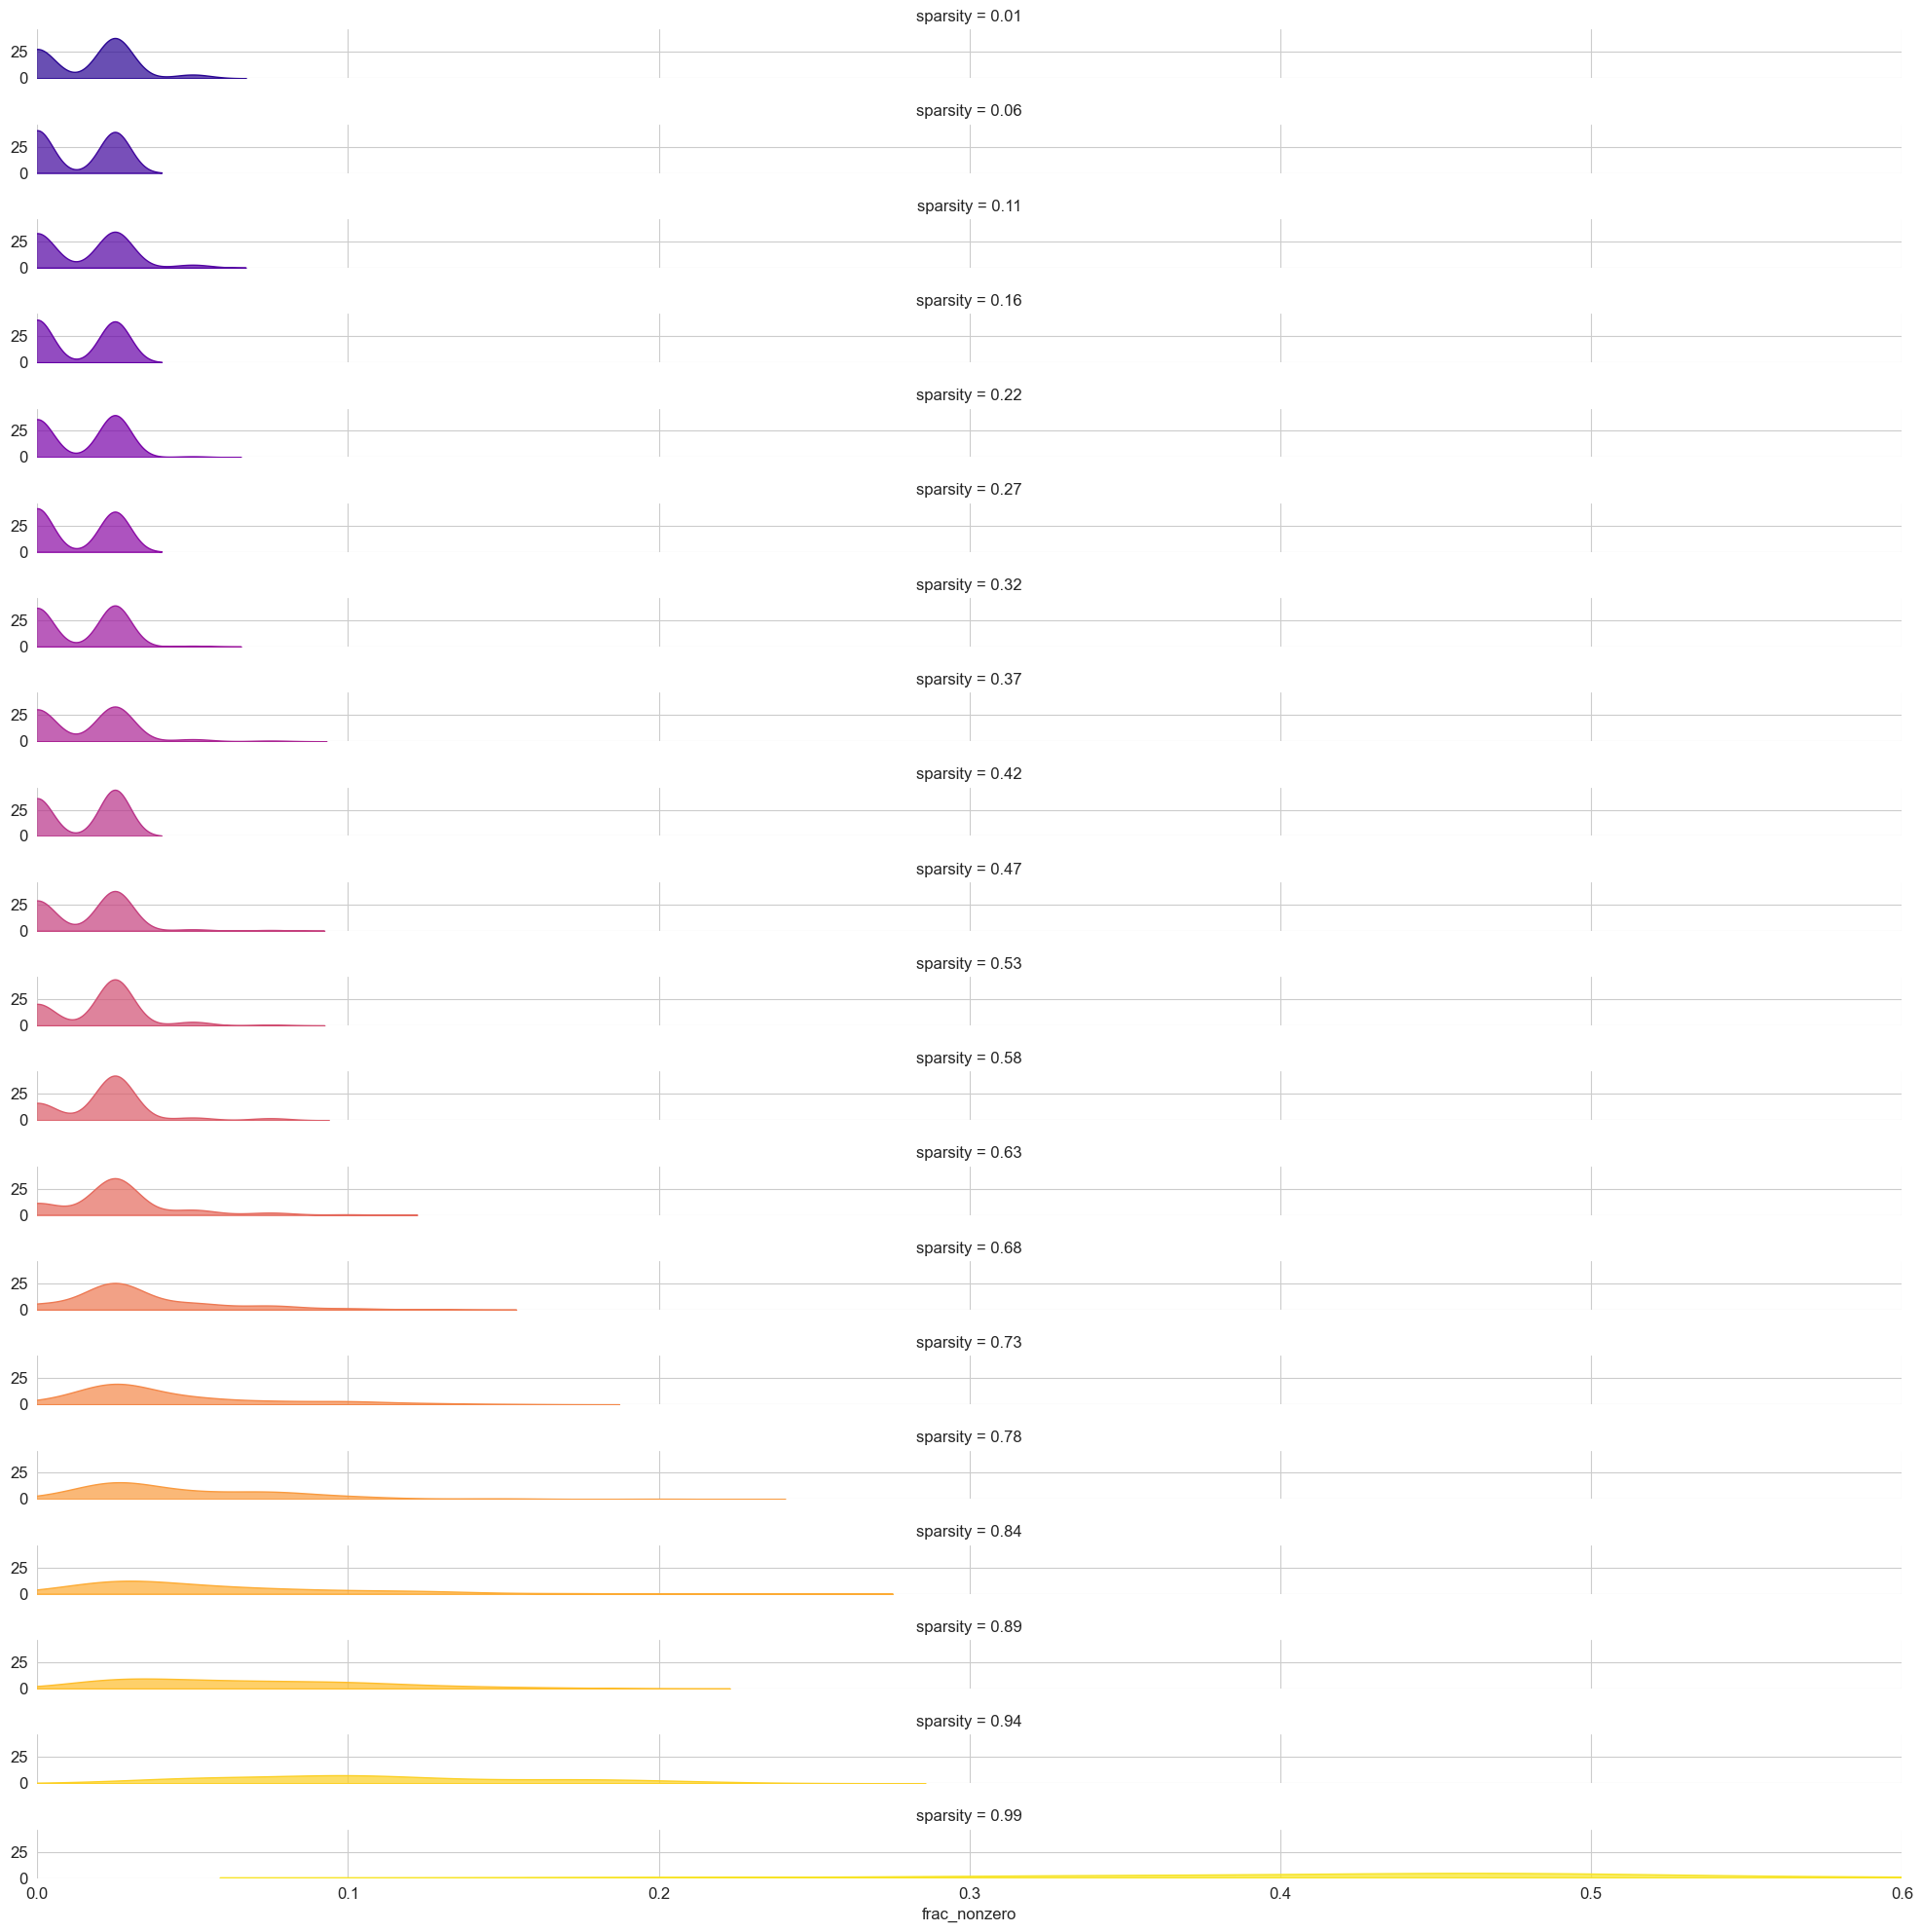

In [317]:
"""Could also potentially plot polysemanticity (and loss) per sparsity level as facetgrid
where each sparsity level has its own axis - but this doesn't look as good imo
"""

g = sns.FacetGrid(
    df_poly,
    row="sparsity",
    hue="sparsity",      # we still color by numeric "sparsity"
    aspect=20,           # wide aspect so we can see the ridgeline shape
    height=1,         # each subplot’s height in inches
    palette="plasma",   
    sharex=True,        # typically we share the same x-axis
    sharey=True
)

g.map(
    sns.kdeplot,
    "frac_nonzero",
    # multiple="stack",
    # element="step",
    fill=True,
    alpha=0.7, 
    # linewidth=1,
    # stat="probability",    # or "probability"
    # binwidth=0.025,
)
g.set(ylabel=None)
g.set(xlim=(0, 0.6))
g.despine(left=True, bottom=True)


## res-mlp

## tms-cis